# Expe 1, injecting noise in participant A2

In [1]:
data_path = '/home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe1'
trial_info_file = '/data/A2/converted/trialinfo_matrix_A2_cleanedtrials.mat'
data_file = '/data/A2/Experimental/data.mat'
epoch_file = '/epochs_from_matrix/epochs_2.fif'

# Posterior electrodes
relevant_electrodes = ['O2','PO4','PO8','P8','P4','P6','P2','P1','P3','P5','P7','PO7','PO3','O1','Pz','POz','Oz','Iz'] 
# Best electrodes in frequency tagging condition
freqtag_electrodes = ['Iz', 'PO3', 'POz', 'P3', 'P7', 'P5']

# Dic to index trial_info matrix
info_colnames = {'0':0 ,'1':1 ,'RT':2,'PTB_check_RT_error':3, 'answer':4,'stimuli_target_interval':5,\
                      'base_delay':6, 'flicker_sides':7, 'cued_side':8, 'orients_L':9, 'orients_r':10,\
                      'ignore_column':11, 'target_angle':12, 'tagging_type':13, 'trial_number':14}

In [2]:
import scipy.io as sio
import scipy
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import mne
from mne.time_frequency import EpochsTFRArray
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from noise_tagging_funs import normalize_per_trial, generate_noise_periods, cross_cor_nois, compute_other_trial_crosscorr

In [3]:
# Load trial info
f = sio.loadmat(f'{data_path}{trial_info_file}')
trial_info = f['all_info']

# Get target binary (i.e if a shift happened)
f = sio.loadmat(f'{data_path}{data_file}')
target_binary =f['data']['targets_binary'][0][0]
# Remove practice trials
target_binary = target_binary[1:,:]
# Collapse to trial indexes
original_shape = target_binary.shape
new_shape = (original_shape[0] * original_shape[1],) + original_shape[2:]
target_binary = np.reshape(target_binary, new_shape)
target_binary = pd.DataFrame({'trial_number':np.arange(target_binary.shape[0]), 'target_binary':target_binary})

# Create pd df to pass to mne metadata
pd_info = pd.DataFrame(trial_info, columns=info_colnames.keys())
pd_info['trial_number']= pd_info['trial_number'].astype(int) - 1
pd_info = pd.merge(pd_info, target_binary, on = 'trial_number')

# Load eeg epochs .fif and add metadata
epochs = mne.read_epochs(f'{data_path}{epoch_file}')
epochs.metadata = pd_info


Reading /home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe1/epochs_from_matrix/epochs_2.fif ...


/tmp/ipykernel_12151/448556551.py:22: RuntimeWarning: This filename (/home/lea/Documents/obsidian_notes/masterADS/ads_thesis_RIFT/my_code_expe1/epochs_from_matrix/epochs_2.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(f'{data_path}{epoch_file}')


    Found the data of interest:
        t =   -1000.00 ...    2299.32 ms
        0 CTF compensation matrices available
Not setting metadata
467 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 16 columns


In [4]:
# Sampling frequency for all the analyses
sfreq = 480
# Keep only posterior electrodes
epochs.pick_channels(relevant_electrodes)

# Keep only trials without targets
epochs = epochs['target_binary == 0']

# Resample to the projectors sampling rate
epochs.resample(sfreq)

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Number of events,380
Events,1: 380
Time range,-1.000 – 2.298 s
Baseline,off


In [5]:
epochs_noistag = epochs['tagging_type==1'].copy()
# Access noise tags
f = sio.loadmat(f'{data_path}{data_file}')
noise_stims = f['data']['noise_stims'][0][0] # block x trial x sequences (L or R tag) x timepoints
# Filter out practice trials
noise_stims = noise_stims[1:,:,:,:]

In [6]:
# Collapse to trial indexes
original_shape = noise_stims.shape
new_shape = (original_shape[0] * original_shape[1],) + original_shape[2:]
noise_stims_tr = np.reshape(noise_stims, new_shape)

# Filter the tag so that impossible frequencies are not in the EEG
noise_stims_tr_fitlered = mne.filter.filter_data(noise_stims_tr, sfreq, None, 100)


Setting up low-pass filter at 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 65 samples (0.135 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.4s


### Adding 2% of tag

In [7]:
epochs_noistag_2 = epochs_noistag.copy()
tmin = epochs_noistag_2.tmin
tmax = epochs_noistag_2.tmax
#Up to when should the tag be present
tmax_noise = 1
# Inject to each EEG epoch its matching cued tag
buffer_arr = epochs_noistag_2.get_data()
# z-score EEG by electrode and trial
buffer_arr = (buffer_arr - np.mean(buffer_arr, axis=2, keepdims=True))/np.std(buffer_arr, axis=2, keepdims=True)
# Reverse the EEG to ensure no real crosscorrelation
buffer_arr = buffer_arr[:,:,::-1]

# After which sample from cue onset should the noise be in the data
for idx, trial in enumerate(epochs_noistag_2.metadata['trial_number']):
    # Delay is the delay between stimulation and translation in brain, here 100ms
    delay = int(.1*sfreq)
    # Offset is the moment where the noise is injected
    offset = int(np.random.normal(.1, .020)*sfreq)
    # Retrieve which tag was cued
    cued_side = int(epochs_noistag_2.metadata[epochs_noistag_2.metadata.trial_number == trial]['cued_side'])
    # Inject the tag displayed from cue onset to 800 ms after
    injected_tag = noise_stims_tr_fitlered[trial, cued_side, \
        :int(tmax_noise*sfreq)+1]
    # z-score tag
    injected_tag = (injected_tag - np.mean(injected_tag))/np.std(injected_tag)
    # Offset the moment of crosscorrelation but preserve phase
    injected_tag[:offset] = 0
    # Relative magnitude of the tag in the EEG
    injected_tag *= 0.0205#0.05265#0.111111#
    # Add the tag from cue onset + time delay (offset)
    buffer_arr[idx,:,int(np.abs(epochs_noistag_2.tmin)*sfreq)+delay:int(np.abs(epochs_noistag_2.tmin)*sfreq+delay)+len(injected_tag)] += injected_tag
epochs_noistag_2._data = buffer_arr
# bandpass (60-80Hz) EEG data 
epochs_noistag_2.filter(l_freq=60, h_freq = 80, verbose=True)

Setting up band-pass filter from 60 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 60.00
- Lower transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 52.50 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 107 samples (0.223 s)



/tmp/ipykernel_12151/3150670137.py:7: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  buffer_arr = epochs_noistag_2.get_data()
/tmp/ipykernel_12151/3150670137.py:20: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cued_side = int(epochs_noistag_2.metadata[epochs_noistag_2.metadata.trial_number == trial]['cued_side'])
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.2s
[Paralle

Number of events,192
Events,1: 192
Time range,-1.000 – 2.298 s
Baseline,off


In [8]:
epochs_noistag_05 = epochs_noistag.copy()

sfreq = 480
tmin = epochs_noistag_05.tmin
tmax = epochs_noistag_05.tmax
#Up to when should the tag be present
tmax_noise = 1
# Inject to each EEG epoch its matching cued tag
buffer_arr = epochs_noistag_05.get_data()
# z-score EEG by electrode and trial
buffer_arr = (buffer_arr - np.mean(buffer_arr, axis=2, keepdims=True))/np.std(buffer_arr, axis=2, keepdims=True)
# Reverse the EEG to ensure no real crosscorrelation
buffer_arr = buffer_arr[:,:,::-1]

# After which sample from cue onset should the noise be in the data
for idx, trial in enumerate(epochs_noistag_05.metadata['trial_number']):
    # Delay is the delay between stimulation and translation in brain, here 100ms
    delay = int(.1*sfreq)
    # Offset is the moment where the noise is injected
    offset = int(np.random.normal(.1, .010)*sfreq)
    # Retrieve which tag was cued
    cued_side = int(epochs_noistag_05.metadata[epochs_noistag_05.metadata.trial_number == trial]['cued_side'])
    # Inject the tag displayed from cue onset to 800 ms after
    injected_tag = noise_stims_tr_fitlered[trial, cued_side, \
        :int(tmax_noise*sfreq)+1]
    # z-score tag
    injected_tag = (injected_tag - np.mean(injected_tag))/np.std(injected_tag)
    # Offset the moment of crosscorrelation but preserve phase
    injected_tag[:offset] = 0
    # Relative magnitude of the tag in the EEG
    injected_tag *= 0.00501
    # Add the tag from cue onset + time delay (offset)
    buffer_arr[idx,:,int(np.abs(epochs_noistag_05.tmin)*sfreq)+delay:int(np.abs(epochs_noistag_05.tmin)*sfreq+delay)+len(injected_tag)] += injected_tag
epochs_noistag_05._data = buffer_arr
# bandpass (60-80Hz) EEG data 
epochs_noistag_05.filter(l_freq=60, h_freq = 80, verbose=True)

/tmp/ipykernel_12151/1512991802.py:9: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  buffer_arr = epochs_noistag_05.get_data()


Setting up band-pass filter from 60 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 60.00
- Lower transition bandwidth: 15.00 Hz (-6 dB cutoff frequency: 52.50 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 107 samples (0.223 s)



/tmp/ipykernel_12151/1512991802.py:22: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  cued_side = int(epochs_noistag_05.metadata[epochs_noistag_05.metadata.trial_number == trial]['cued_side'])
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 2591 tasks 

Number of events,192
Events,1: 192
Time range,-1.000 – 2.298 s
Baseline,off


## 1. Cross-correlation of the cued and uncued tags (tag duration from 0 to 1s)

The EEG from -1 to 2s is correlated with the tags from 0 to 1s (positive time lag up to 1000ms). 
Only trials without targets are included. 
The EEG is correlated with each tag.
The electrodes used are the best from the frequency tagging condition.

Text(0, 0.5, 'Cor EEG/tag')

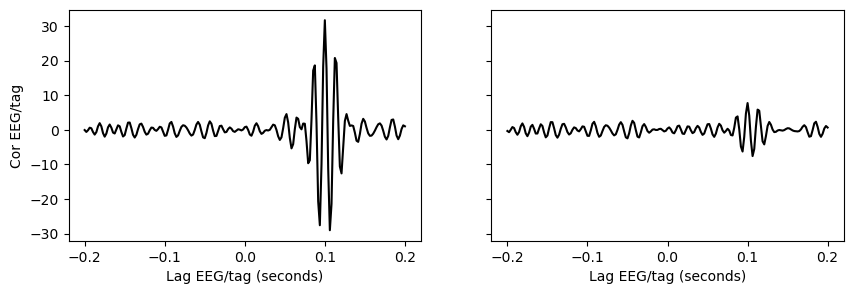

In [18]:
sfreq = 480 # EEG and tag 
tmin_eeg, tmax_eeg = -1, 2
tmin_noise, tmax_noise = 0, 1
tmin_display = int(.8*sfreq) #Display from -.2 s

cor_with_cued_for_cuedR, cor_with_uncued_for_cuedR, idx_cuedR, times = \
    cross_cor_nois(epochs_fun = epochs_noistag_2['target_binary == 0'], noise=noise_stims_tr, \
    display_side_cued_tag = 'right', electrodes = freqtag_electrodes,\
    sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, tmin_noise = tmin_noise, tmax_noise = tmax_noise,
    mean_tags = False)

cor_with_cued_for_cuedL, cor_with_uncued_for_cuedL, idx_cuedL, times = \
    cross_cor_nois(epochs_noistag_2['target_binary == 0'], noise_stims_tr, 'left', electrodes = freqtag_electrodes,\
    sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, tmin_noise = tmin_noise, tmax_noise = tmax_noise,
    mean_tags = False)

cor_with_cued_2 = np.concatenate([cor_with_cued_for_cuedR,cor_with_cued_for_cuedL])

cor_with_cued_for_cuedR, cor_with_uncued_for_cuedR, idx_cuedR, times = \
    cross_cor_nois(epochs_fun = epochs_noistag_05['target_binary == 0'], noise=noise_stims_tr, \
    display_side_cued_tag = 'right', electrodes = freqtag_electrodes,\
    sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, tmin_noise = tmin_noise, tmax_noise = tmax_noise,
    mean_tags = False)

cor_with_cued_for_cuedL, cor_with_uncued_for_cuedL, idx_cuedL, times = \
    cross_cor_nois(epochs_noistag_05['target_binary == 0'], noise_stims_tr, 'left', electrodes = freqtag_electrodes,\
    sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, tmin_noise = tmin_noise, tmax_noise = tmax_noise,
    mean_tags = False)

cor_with_cued_05 = np.concatenate([cor_with_cued_for_cuedR,cor_with_cued_for_cuedL])

# Plot
fig, ax = plt.subplots(1,2, sharey=True, sharex=True, figsize=(10,3))

ax[0].plot(times[tmin_display:-tmin_display],cor_with_cued_2.mean(axis=(0,1)).T[tmin_display:-tmin_display], color='black')
ax[1].plot(times[tmin_display:-tmin_display],cor_with_cued_05.mean(axis=(0,1)).T[tmin_display:-tmin_display], color='black')

ax[0].set_xlabel('Lag EEG/tag (seconds)')
ax[1].set_xlabel('Lag EEG/tag (seconds)')
ax[0].set_ylabel('Cor EEG/tag')

## 2. Trial averaged analysis

### 2.1 pre vs post-display

T-test for pre vs post on 2%:TtestResult(statistic=-41.17821475029728, pvalue=1.5930375809759734e-07, df=5)
T-test for pre vs post on 0.05%:TtestResult(statistic=-5.725864927714843, pvalue=0.0022735540879570116, df=5)


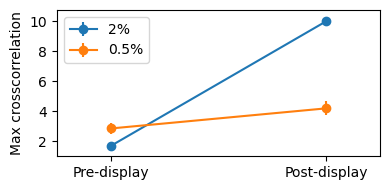

In [23]:
plt.subplots(figsize=(4,2))
max_precue_cued_2 = np.abs(normalize_per_trial(np.mean(cor_with_cued_2, axis=0))[:,:int(times.max()*sfreq)]).max(axis=-1)
max_postcue_cued_2 = np.abs(normalize_per_trial(np.mean(cor_with_cued_2, axis=0))[:,-int(times.max()*sfreq):]).max(axis=-1)
plt.errorbar(x=[0,1], y=[np.mean(max_precue_cued_2), np.mean(max_postcue_cued_2)],
                yerr=[np.std(max_precue_cued_2), np.std(max_postcue_cued_2)], fmt='o-', label='2%')
print(f'T-test for pre vs post on 2%:{scipy.stats.ttest_rel(max_precue_cued_2,max_postcue_cued_2)}')
max_precue_cued_05 = np.abs(normalize_per_trial(np.mean(cor_with_cued_05, axis=0))[:,:int(times.max()*sfreq)]).max(axis=-1)
max_postcue_cued_05 = np.abs(normalize_per_trial(np.mean(cor_with_cued_05, axis=0))[:,-int(times.max()*sfreq):]).max(axis=-1)
plt.errorbar(x=[0,1], y=[np.mean(max_precue_cued_05), np.mean(max_postcue_cued_05)],
                yerr=[np.std(max_precue_cued_05), np.std(max_postcue_cued_05)], fmt='o-', label='0.5%')
print(f'T-test for pre vs post on 0.05%:{scipy.stats.ttest_rel(max_precue_cued_05,max_postcue_cued_05)}')
plt.xticks([0,1],['Pre-display', 'Post-display'])
# plt.title('Maximum crosscorrelation averaged over trials and electrodes prior vs after the cue')
plt.ylabel('Max crosscorrelation')
plt.xlim(-.25, 1.25)
plt.legend(loc=2)
plt.tight_layout()

### 2.2 Comparing max cross-correlation on displayed trial vs others

In [11]:
tmin_eeg, tmax_eeg = 0, epochs_noistag_2.tmax
tmin_noise, tmax_noise = 0, 2

# First for left cued side
trials = epochs_noistag_2.metadata['trial_number'][epochs_noistag_2['cued_side == 0'].selection]
# (cued, uncued), trial, elec, time
trial_crosscorr_matL_2 = np.zeros((2, len(trials), len(trials), len(freqtag_electrodes), int(np.round((tmax_eeg-tmax_noise)*sfreq))+1))

for trial_idx, trial in enumerate(trials):
    trial_noise = copy.deepcopy(noise_stims_tr)
    # Repeat the two noise sequences across all trials 
    trial_noise = np.tile(trial_noise[trial], (len(noise_stims_tr),1, 1))
    # Perform cross-correlation on the repeated noise and all eeg trials
    cor_with_cued_for_cuedL, cor_with_uncued_for_cuedL, idx_cuedL, times = cross_cor_nois(epochs_fun = epochs_noistag_2, noise=trial_noise, \
        display_side_cued_tag = 'left', electrodes=freqtag_electrodes, \
        sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, \
        tmin_noise = tmin_noise, tmax_noise = tmax_noise)
    
    # Record trial result for cued and uncued
    trial_crosscorr_matL_2[0, trial_idx, :, :, :] = cor_with_cued_for_cuedL[:, :, :]
    trial_crosscorr_matL_2[1, trial_idx, :, :, :] = cor_with_uncued_for_cuedL[:, :, :]

# For right cued side
trials = epochs_noistag_2.metadata['trial_number'][epochs_noistag_2['cued_side == 1'].selection]
trial_crosscorr_matR_2 = np.zeros((2, len(trials), len(trials), len(freqtag_electrodes), int(np.round((tmax_eeg-tmax_noise)*sfreq))+1))

for trial_idx, trial in enumerate(trials):
    trial_noise = copy.deepcopy(noise_stims_tr)
    # Repeat the two noise sequences across all trials 
    trial_noise = np.tile(trial_noise[ trial], (len(noise_stims_tr),1, 1))
    # Perform cross-correlation on the repeated noise and all eeg trials
    cor_with_cued_for_cuedR, cor_with_uncued_for_cuedR, idx_cuedR, times = cross_cor_nois(epochs_fun = epochs_noistag_2, noise=trial_noise, \
        display_side_cued_tag = 'right', electrodes=freqtag_electrodes,  \
        sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, \
        tmin_noise = tmin_noise, tmax_noise = tmax_noise)
    
    # Record trial result for cued and uncued
    trial_crosscorr_matR_2[0, trial_idx, :, :, :] = cor_with_cued_for_cuedR[:, :, :]
    trial_crosscorr_matR_2[1, trial_idx, :, :, :] = cor_with_uncued_for_cuedR[:, :, :]

In [12]:
tmin_eeg, tmax_eeg = 0, epochs_noistag_05.tmax
tmin_noise, tmax_noise = 0, 2

# First for left cued side
trials = epochs_noistag_05.metadata['trial_number'][epochs_noistag_05['cued_side == 0'].selection]
# (cued, uncued), trial, elec, time
trial_crosscorr_matL_05 = np.zeros((2, len(trials), len(trials), len(freqtag_electrodes), int(np.round((tmax_eeg-tmax_noise)*sfreq))+1))

for trial_idx, trial in enumerate(trials):
    trial_noise = copy.deepcopy(noise_stims_tr)
    # Repeat the two noise sequences across all trials 
    trial_noise = np.tile(trial_noise[trial], (len(noise_stims_tr),1, 1))
    # Perform cross-correlation on the repeated noise and all eeg trials
    cor_with_cued_for_cuedL, cor_with_uncued_for_cuedL, idx_cuedL, times = cross_cor_nois(epochs_fun = epochs_noistag_05, noise=trial_noise, \
        display_side_cued_tag = 'left', electrodes=freqtag_electrodes, \
        sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, \
        tmin_noise = tmin_noise, tmax_noise = tmax_noise)
    
    # Record trial result for cued and uncued
    trial_crosscorr_matL_05[0, trial_idx, :, :, :] = cor_with_cued_for_cuedL[:, :, :]
    trial_crosscorr_matL_05[1, trial_idx, :, :, :] = cor_with_uncued_for_cuedL[:, :, :]

# For right cued side
trials = epochs_noistag_05.metadata['trial_number'][epochs_noistag_05['cued_side == 1'].selection]
trial_crosscorr_matR_05 = np.zeros((2, len(trials), len(trials), len(freqtag_electrodes), int(np.round((tmax_eeg-tmax_noise)*sfreq))+1))

for trial_idx, trial in enumerate(trials):
    trial_noise = copy.deepcopy(noise_stims_tr)
    # Repeat the two noise sequences across all trials 
    trial_noise = np.tile(trial_noise[ trial], (len(noise_stims_tr),1, 1))
    # Perform cross-correlation on the repeated noise and all eeg trials
    cor_with_cued_for_cuedR, cor_with_uncued_for_cuedR, idx_cuedR, times = cross_cor_nois(epochs_fun = epochs_noistag_05, noise=trial_noise, \
        display_side_cued_tag = 'right', electrodes=freqtag_electrodes,  \
        sampling_freq = sfreq, tmin_eeg=tmin_eeg, tmax_eeg=tmax_eeg, \
        tmin_noise = tmin_noise, tmax_noise = tmax_noise)
    
    # Record trial result for cued and uncued
    trial_crosscorr_matR_05[0, trial_idx, :, :, :] = cor_with_cued_for_cuedR[:, :, :]
    trial_crosscorr_matR_05[1, trial_idx, :, :, :] = cor_with_uncued_for_cuedR[:, :, :]

T-test for same vs other on 2%:TtestResult(statistic=16.461581968824024, pvalue=1.4263855893206963e-08, df=10.0)
T-test for same vs other on 0.05%:TtestResult(statistic=3.811652433180005, pvalue=0.003419943600681157, df=10.0)


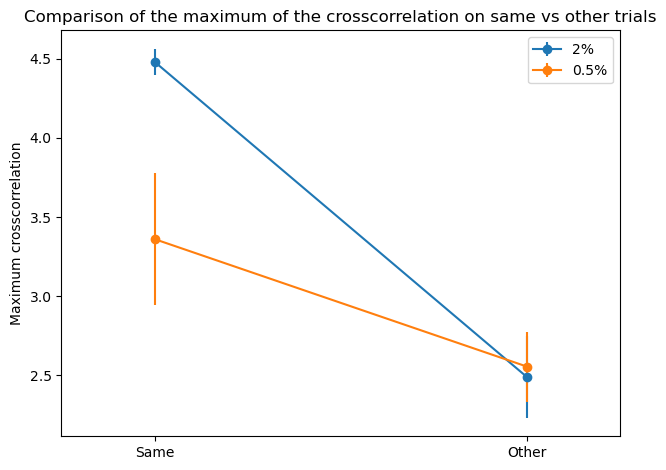

In [13]:
# Set seed for reproducibility of the random choice on other trials
np.random.seed(1)

same_cued_2, same_cued_05 = [], []
other_cued_2, other_cued_05 = [], []

num_trials = trial_crosscorr_matL_2[0].shape[0]
for trial in range(num_trials):
    # Pick the same trial by taking the diagonal
    same_cued_2.append(trial_crosscorr_matL_2[0][trial, trial])
    # Randomly pick an other trial (but not the same trial)
    possible_indices = list(range(num_trials))
    possible_indices.remove(trial)
    sampled_index = np.random.choice(possible_indices)
    # Store this random other trial
    other_cued_2.append(trial_crosscorr_matL_2[0][trial, sampled_index])
    
num_trials = trial_crosscorr_matR_2[0].shape[0]
for trial in range(num_trials):
    same_cued_2.append(trial_crosscorr_matR_2[0][trial, trial])
    # Randomly pick an other trial (but not the same trial)
    possible_indices = list(range(num_trials))
    possible_indices.remove(trial)
    sampled_index = np.random.choice(possible_indices)
    # Store this random other trial
    other_cued_2.append(trial_crosscorr_matR_2[0][trial, sampled_index])

num_trials = trial_crosscorr_matL_05[0].shape[0]
for trial in range(num_trials):
    # Pick the same trial by taking the diagonal
    same_cued_05.append(trial_crosscorr_matL_05[0][trial, trial])
    # Randomly pick an other trial (but not the same trial)
    possible_indices = list(range(num_trials))
    possible_indices.remove(trial)
    sampled_index = np.random.choice(possible_indices)
    # Store this random other trial
    other_cued_05.append(trial_crosscorr_matL_05[0][trial, sampled_index])
    
num_trials = trial_crosscorr_matR_05[0].shape[0]
for trial in range(num_trials):
    same_cued_05.append(trial_crosscorr_matR_05[0][trial, trial])
    # Randomly pick an other trial (but not the same trial)
    possible_indices = list(range(num_trials))
    possible_indices.remove(trial)
    sampled_index = np.random.choice(possible_indices)
    # Store this random other trial
    other_cued_05.append(trial_crosscorr_matR_05[0][trial, sampled_index])

plt.errorbar(x=[0,1], y=[np.abs(normalize_per_trial(np.array(same_cued_2).mean(axis=(0))).max(axis=-1).mean()), np.abs(normalize_per_trial(np.array(other_cued_2).mean(axis=(0))).max(axis=-1).mean())],
                yerr=[np.abs(normalize_per_trial(np.array(same_cued_2).mean(axis=(0))).max(axis=-1).std()), np.abs(normalize_per_trial(np.array(other_cued_2).mean(axis=(0))).max(axis=-1).std())], fmt='o-', label='2%')
print(f'T-test for same vs other on 2%:{scipy.stats.ttest_ind(np.abs(normalize_per_trial(np.array(same_cued_2).mean(axis=(0))).max(axis=-1)),\
                                                                     np.abs(normalize_per_trial(np.array(other_cued_2).mean(axis=(0))).max(axis=-1)))}')

plt.errorbar(x=[0,1], y=[np.abs(normalize_per_trial(np.array(same_cued_05).mean(axis=(0))).max(axis=-1).mean()), np.abs(normalize_per_trial(np.array(other_cued_05).mean(axis=(0))).max(axis=-1).mean())],
                yerr=[np.abs(normalize_per_trial(np.array(same_cued_05).mean(axis=(0))).max(axis=-1).std()), np.abs(normalize_per_trial(np.array(other_cued_05).mean(axis=(0))).max(axis=-1).std())], fmt='o-', label='0.5%')
print(f'T-test for same vs other on 0.05%:{scipy.stats.ttest_ind(np.abs(normalize_per_trial(np.array(same_cued_05).mean(axis=(0))).max(axis=-1)),\
                                                                     np.abs(normalize_per_trial(np.array(other_cued_05).mean(axis=(0))).max(axis=-1)))}')
plt.xticks([0,1],['Same', 'Other'])
plt.title('Comparison of the maximum of the crosscorrelation on same vs other trials')
plt.ylabel('Maximum crosscorrelation')
plt.legend()
plt.xlim(-.25, 1.25)
plt.tight_layout()

## 3. Trial-by-trial analysis

### 3.1 Comparing by trial cross-correlation on displayed trial vs others

T-test for same vs others on cued:TtestResult(statistic=2.944247604150145, pvalue=0.003632342701264983, df=194.26706974800808)
T-test for same vs others on cued:TtestResult(statistic=-0.391254588204737, pvalue=0.696036674895779, df=194.80047553163132)


/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/lea/anaconda3/envs/ads_thesis/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprec

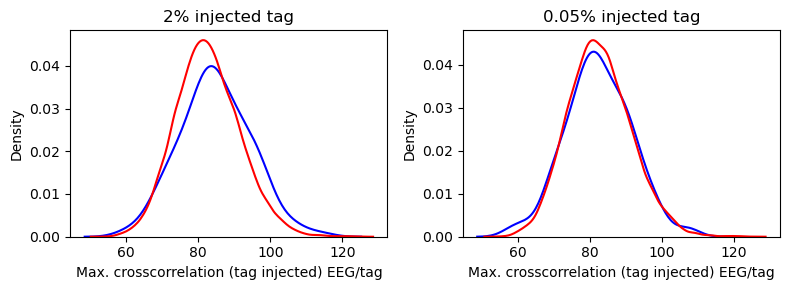

In [14]:
fig, ax = plt.subplots(1,2, figsize=(8,3))

# Extract the max for each trial, average cor over best noise tagging electrodes
trialL = np.mean(np.abs(trial_crosscorr_matL_2[0][:, :, :,:].max(axis=-1)), axis=2)
trialR = np.mean(np.abs(trial_crosscorr_matR_2[0][:, :, :,:].max(axis=-1)), axis=2)

# Group cor with EEG from the trial VS with EEG from all other trials
same_trial = np.concatenate([np.diagonal(trialL), np.diagonal(trialR)])
other_trial = np.concatenate([trialL[~np.eye(trialL.shape[0], dtype=bool)],\
                           trialR[~np.eye(trialR.shape[0], dtype=bool)]])
print(f'T-test for same vs others on cued:{scipy.stats.ttest_ind(same_trial,other_trial,equal_var=False)}')
sns.kdeplot(same_trial, color='blue', ax=ax[0])
sns.kdeplot(other_trial, color='red', ax=ax[0])


# Extract the max for each trial, average cor over best noise tagging electrodes
trialL = np.mean(np.abs(trial_crosscorr_matL_05[0][:, :, :,:].max(axis=-1)), axis=2)
trialR = np.mean(np.abs(trial_crosscorr_matR_05[0][:, :, :,:].max(axis=-1)), axis=2)

# Group cor with EEG from the trial VS with EEG from all other trials
same_trial = np.concatenate([np.diagonal(trialL), np.diagonal(trialR)])
other_trial = np.concatenate([trialL[~np.eye(trialL.shape[0], dtype=bool)],\
                           trialR[~np.eye(trialR.shape[0], dtype=bool)]])
print(f'T-test for same vs others on cued:{scipy.stats.ttest_ind(same_trial,other_trial,equal_var=False)}')
sns.kdeplot(same_trial, color='blue', ax=ax[1])
sns.kdeplot(other_trial, color='red', ax=ax[1])


ax[0].set_xlabel('Max. crosscorrelation (tag injected) EEG/tag')
ax[1].set_xlabel('Max. crosscorrelation (tag injected) EEG/tag')
ax[0].set_title('2% injected tag')
ax[1].set_title('0.05% injected tag')
plt.tight_layout()

Sampling frequency of the instance is already 480.0, returning unmodified.


/tmp/ipykernel_12151/2022885896.py:22: FutureWarning: The default value of `zero_mean` will change from `False` to `True` in version 1.8. Set the value explicitly to avoid this warning.
  itc_same_2 = mne.time_frequency.tfr_array_morlet(same_cued_2, epochs_noistag_2_cropped.info['sfreq'], freqs, n_cycles=10, output='itc')


Sampling frequency of the instance is already 480.0, returning unmodified.


/tmp/ipykernel_12151/2022885896.py:39: FutureWarning: The default value of `zero_mean` will change from `False` to `True` in version 1.8. Set the value explicitly to avoid this warning.
  itc_same_05 = mne.time_frequency.tfr_array_morlet(same_cued_05, epochs_noistag_05_cropped.info['sfreq'], freqs, n_cycles=10, output='itc')


Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


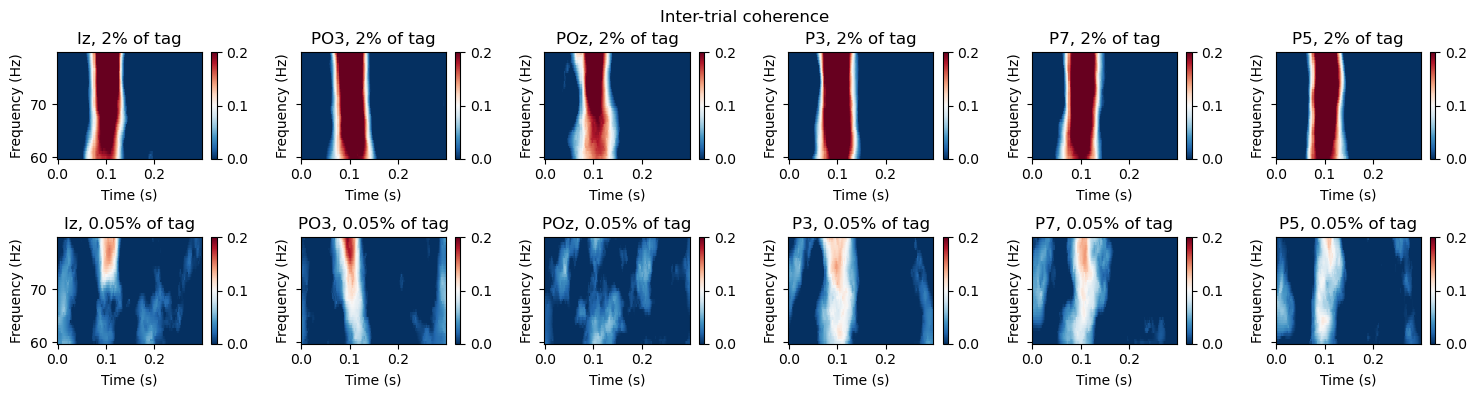

In [15]:
tmin_eeg, tmax_eeg = 0, epochs_noistag_2.tmax
tmin_noise, tmax_noise = 0, 2

# Perform a time-frequency analysis of the cross-correlation
freqs = np.arange(60, 80, step = 0.5)

same_cued_2, same_cued_05 = [], []
other_cued_2, other_cued_05 = [], []

num_trials = trial_crosscorr_matL_2[0].shape[0]
for trial in range(num_trials):
    # Pick the same trial by taking the diagonal
    same_cued_2.append(trial_crosscorr_matL_2[0][trial, trial])

num_trials = trial_crosscorr_matR_2[0].shape[0]
for trial in range(num_trials):
    same_cued_2.append(trial_crosscorr_matR_2[0][trial, trial])

# Adapt the eeg info
epochs_noistag_2_cropped = epochs_noistag_2.copy().crop(tmin=tmin_eeg, tmax=tmax_eeg-(tmax_noise-tmin_noise)).pick(freqtag_electrodes).resample(sfreq)
# Do the time frequency analysis
itc_same_2 = mne.time_frequency.tfr_array_morlet(same_cued_2, epochs_noistag_2_cropped.info['sfreq'], freqs, n_cycles=10, output='itc')
# Store in MNE format
itc_same_2 = mne.time_frequency.EpochsTFRArray(epochs_noistag_2_cropped.info, np.array([itc_same_2]), epochs_noistag_2_cropped.times, freqs)

num_trials = trial_crosscorr_matL_05[0].shape[0]
for trial in range(num_trials):
    # Pick the same trial by taking the diagonal
    same_cued_05.append(trial_crosscorr_matL_05[0][trial, trial])

num_trials = trial_crosscorr_matR_05[0].shape[0]
for trial in range(num_trials):
    same_cued_05.append(trial_crosscorr_matR_05[0][trial, trial])

    
# Adapt the eeg info
epochs_noistag_05_cropped = epochs_noistag_05.copy().crop(tmin=tmin_eeg, tmax=tmax_eeg-(tmax_noise-tmin_noise)).pick(freqtag_electrodes).resample(sfreq)
# Do the time frequency analysis
itc_same_05 = mne.time_frequency.tfr_array_morlet(same_cued_05, epochs_noistag_05_cropped.info['sfreq'], freqs, n_cycles=10, output='itc')
# Store in MNE format
itc_same_05 = mne.time_frequency.EpochsTFRArray(epochs_noistag_05_cropped.info, np.array([itc_same_05]), epochs_noistag_05_cropped.times, freqs)


# Plot
fig, axes = plt.subplots(2, len(freqtag_electrodes), figsize=(15, 4), sharey = True) 
channels = epochs_noistag_2_cropped.info['ch_names']
for e, channel in enumerate(channels):
    itc_same_2.plot(
        [channel],
        baseline=(None,None),
        vlim=(0, .2),
        axes=axes[0, e],
        colorbar=True,
        show=False 
    )
    axes[0,e].set_title(f'{channel}, 2% of tag')
    itc_same_05.plot(
        [channel],
        baseline=(None,None),
        vlim=(0, .2),
        axes=axes[1, e],
        colorbar=True,
        show=False 
    )
    axes[1,e].set_title(f'{channel}, 0.05% of tag')
plt.tight_layout()
plt.suptitle('Inter-trial coherence')
plt.show()